# PS reconstruction, Gaussian beam

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import facet_ii_SC20
from phase_space_reconstruction.virtual.scans import run_3d_scan, run_t_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.visualization import plot_3d_scan_data
from phase_space_reconstruction.train import train_3d_scan, train_3d_scan_parallel_gpus

from bmadx.distgen_utils import create_beam
from bmadx.plot import plot_projections
from bmadx.constants import PI

## Create synthetic ground truth beam

In [2]:
from copy import deepcopy
gt_beam = torch.load("facet_ii_beam.pt")

print(gt_beam.data.shape)
subsample_beam = deepcopy(gt_beam)
subsample_beam.data = subsample_beam.data[::10]

torch.Size([999115, 6])


(<Figure size 1200x1200 with 36 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='px (mrad)'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='y (mm)'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: ylabel='py (mrad)'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='z (mm)'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: xlabel='x (mm)', ylabel='pz (%)'>,
         <Axes: xlabel='px (mrad)'>, <Axes: xlabel='y (mm)'>,
         <Axes: xlabel='py (mrad)'>, <Axes: xlabel='z (mm)'>,
         <Axes: xlabel='pz (%)'>]], dtype=object))

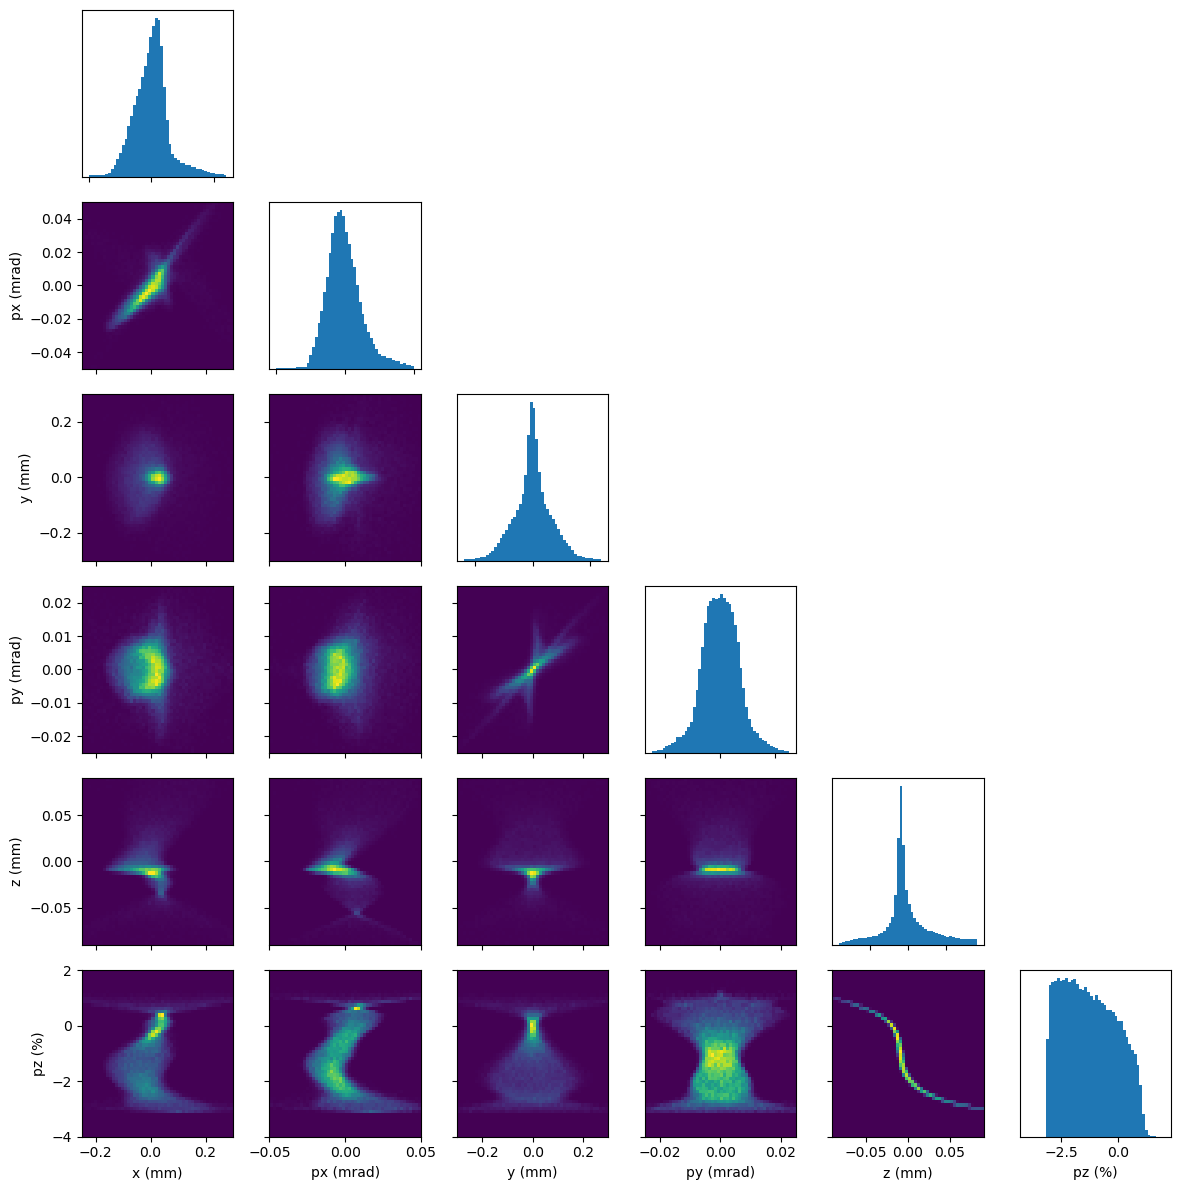

In [3]:
from bmadx.plot import plot_projections
lims = np.array([
    [-2.5e-4,3e-4],
    [-0.5e-4,0.5e-4],
    [-3e-4,3e-4],
    [-25e-6,25e-6],
    [-0.9e-4, 0.9e-4],
    [-4e-2,2e-2]
])
plot_projections(
    subsample_beam,
    custom_lims=lims
)

## Define diagnostics lattice parameters

In [4]:
# diagnostic beamline:
p0c=10e9
lattice = facet_ii_SC20(p0c=p0c, dipole_on=False)


# Scan over quad strength, tdc on/off and dipole on/off
scan_ids = [0, 2, 4] 
n_ks = 11
ks = torch.linspace(-0.6, 0.6, n_ks) # quad ks
vs = torch.tensor([0, 3.5e7]) # TDC off/on
gs = torch.tensor([6.1356e-3*0.75, 6.1356e-3*1.2]) # dipole off/on
train_params = torch.stack(torch.meshgrid(ks, vs, gs, indexing='ij'))
print(train_params.shape)
print(train_params.unsqueeze(-1).shape)

# create diagnostic screen: 
bins = torch.linspace(-3.5, 3.5, 100) * 1e-3
bandwidth = (bins[1]-bins[0]) / 2
screen = ImageDiagnostic(bins, bins, bandwidth)
print(float(bins[1]-bins[0])*1e6,"um")

torch.Size([3, 11, 2, 2])
torch.Size([3, 11, 2, 2, 1])
70.70694118738174 um


## Complete 3D scan training data

In [5]:
# generate and save train and test datasets
train_dset_3d_scan = run_3d_scan(
    gt_beam, 
    lattice,
    screen, 
    ks, vs, gs,
    ids = scan_ids,
    save_as = os.path.join('3d_scan_train.dset')
    )

print(train_dset_3d_scan.params.shape)
print(train_dset_3d_scan.images.shape)

dataset saved as '3d_scan_train.dset'
torch.Size([44, 3, 1])
torch.Size([44, 1, 100, 100])


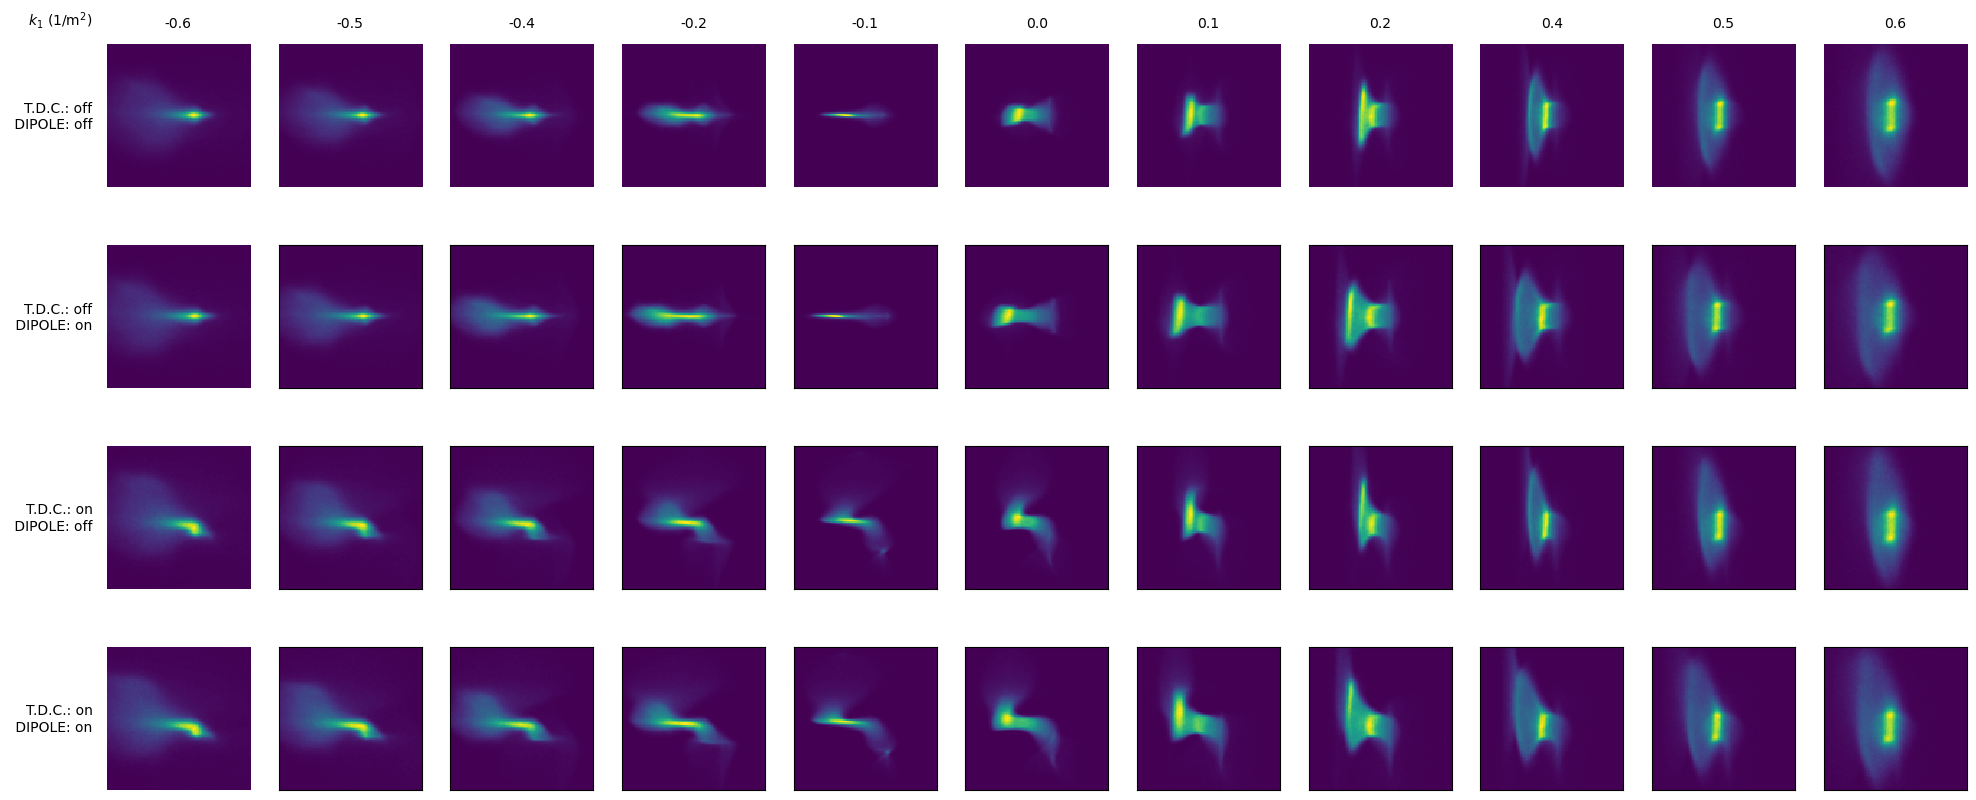

In [6]:
fig, ax = plot_3d_scan_data(train_dset_3d_scan)
fig.savefig("facet_data.png",dpi=300)
fig.savefig("facet_data.svg")
plt.show()

In [ ]:
%%time
from phase_space_reconstruction.modeling import NNTransform


# training with 4 gpus
pred_beam_3d_scan_10_000, model = train_3d_scan(
    train_dset_3d_scan, 
    lattice, 
    p0c, 
    screen, 
    ids = scan_ids,
    n_epochs = 10_000, 
    n_particles = 100_000, 
    device = 'cuda:0',
    lambda_=1e14,
    save_dir = ".",
    nn_transform=NNTransform(2, 20, output_scale=1e-4),
    distribution_dump_frequency=500,
    distribution_dump_n_particles=1_000_000,
    )

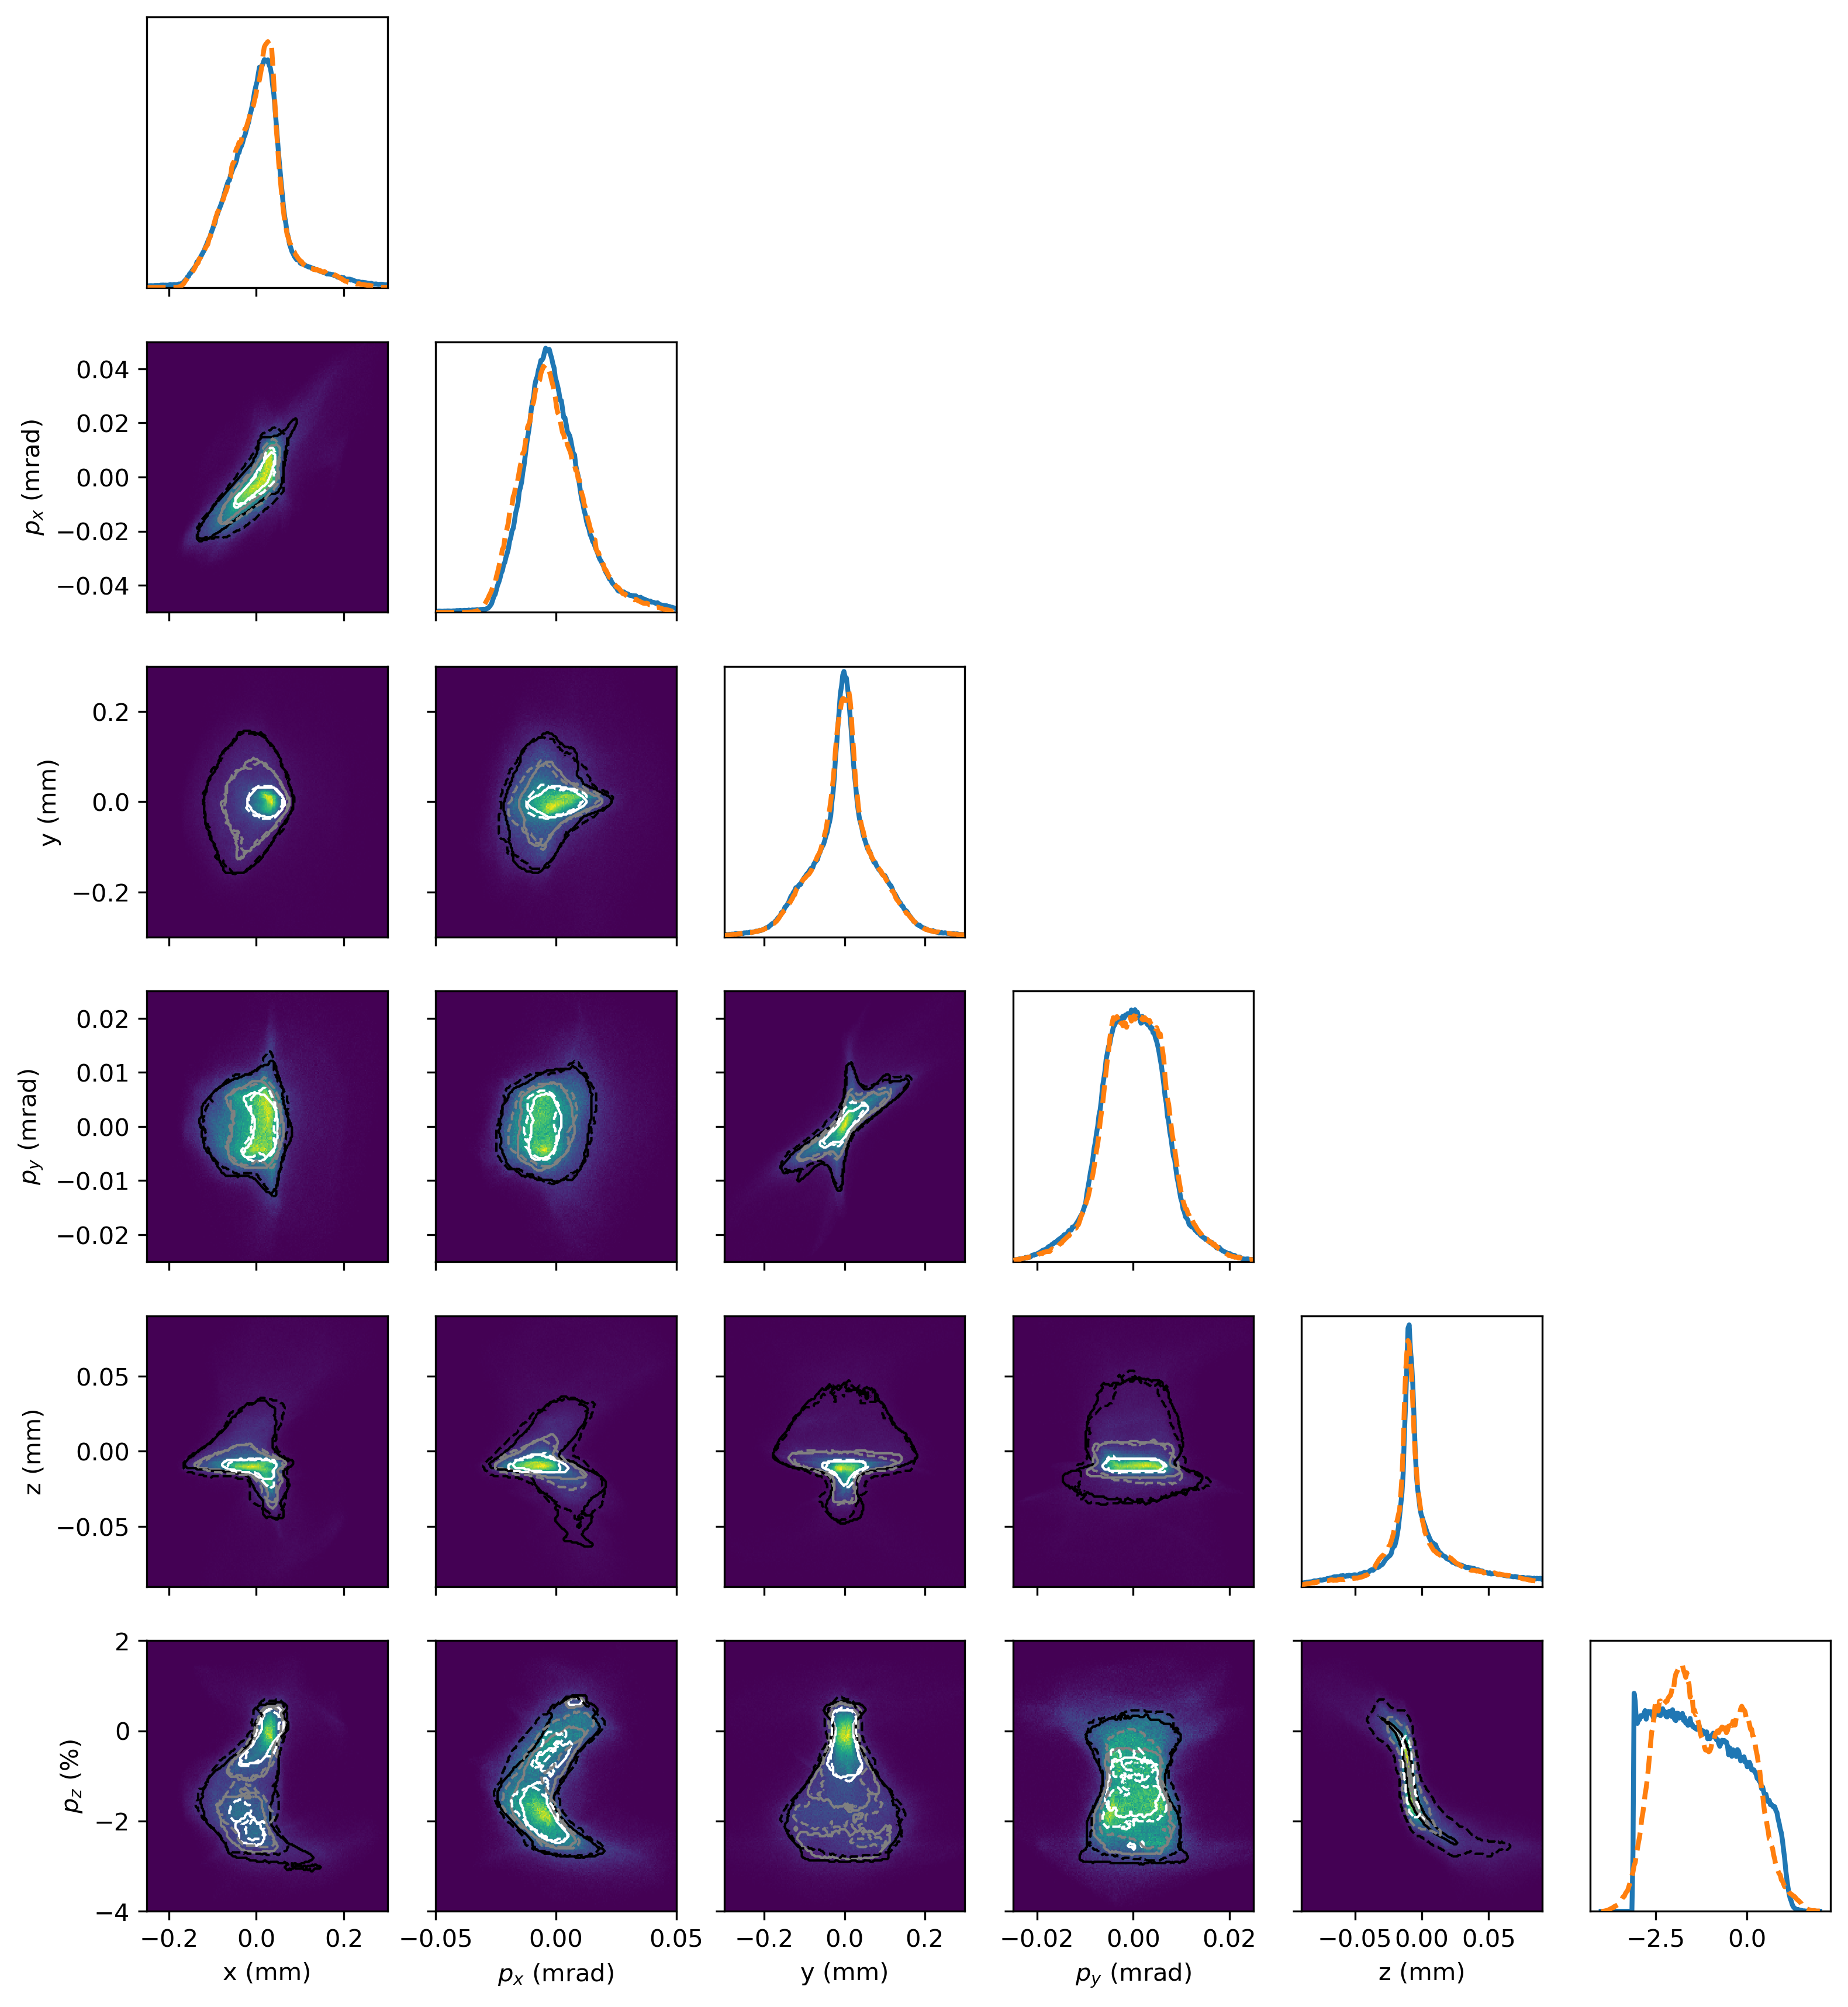

In [7]:
import torch
from stats import plot_projections_with_contours, show_cov_stats
import os
import numpy as np

lims = np.array([
    [-2.5e-4,3e-4],
    [-0.5e-4,0.5e-4],
    [-3e-4,3e-4],
    [-25e-6,25e-6],
    [-0.9e-4, 0.9e-4],
    [-4e-2,2e-2]
])*1e3
lims[-1] = [-4,2]

recn_dist = torch.load(os.path.join('dist_6000.pt'))
recn_dist.data = recn_dist.data
fig,ax = plot_projections_with_contours(
    recn_dist,
    gt_beam,
    n_bins=200,
    contour_percentiles = [25,50,75],
    custom_lims=lims,
    contour_smoothing=0.25,
)
fig.savefig("facet_single_beam_reconstruction.svg")

In [9]:
pred_dset_3d_scan = run_3d_scan(
    recn_dist, 
    lattice,
    screen, 
    ks, vs, gs,
    ids = scan_ids,
    #save_as = os.path.join('3d_scan_train.dset')
    )

In [ ]:
plot_3d_scan_data(pred_dset_3d_scan)

In [ ]:
pred_dset_3d_scan.images.shape

In [ ]:
train_dset_3d_scan.images.shape

In [8]:
pred_dset_3d_scan.params = pred_dset_3d_scan.params.reshape(11,2,2,3)


NameError: name 'pred_dset_3d_scan' is not defined

In [10]:
pred_dset_3d_scan.images = pred_dset_3d_scan.images.reshape(11,2,2,100,100)[::3]
train_dset_3d_scan.images = train_dset_3d_scan.images.reshape(11,2,2,100,100)[::3]


In [13]:
from analysis_scripts import get_beam_fraction_hist2d
from matplotlib.lines import Line2D
from scipy.ndimage import gaussian_filter
from phase_space_reconstruction.modeling import ImageDataset3D
def plot_3d_scan_data_2screens_contour2(
    pred_dset, 
    test_dset, 
    select_img = 'avg', 
    contour_percentiles = [50, 85],
    contour_smoothing_r = 1,
    contour_smoothing_gt = 1,
    screen_0_len = None,
    screen_1_len = None,
    vmax1=None,
    vmax2=None
):

    n_contours = len(contour_percentiles)
    COLORS = ["white", "gray", "black"]
    COLORS = COLORS * (n_contours // int(len(COLORS)+0.1) + 1)
    pred_imgs = pred_dset.images
    test_imgs = test_dset.images
        
    params = pred_dset.images
    n_k = params.shape[0]
    n_v = params.shape[1]
    n_g = params.shape[2]
    
    print(n_k,n_v,n_g)
    fig, ax = plt.subplots(
        n_v * n_g + 1,
        n_k + 1,
        figsize=( (n_k+1)*2, (n_v*n_g+1)*2 ),
    )
    ax[0, 0].set_axis_off()
    ax[0, 0].text(1, 0, '$k_1$ (1/m$^2$)', va='bottom', ha='right')
    corners=None
    centers=None
    if screen_0_len is not None:
        corners_0 = torch.linspace(-screen_0_len/2, screen_0_len/2, test_imgs.shape[-1]+1)*1e3
        corners_1 = torch.linspace(-screen_1_len/2, screen_1_len/2, test_imgs.shape[-1]+1)*1e3
    
    for i in range(n_k):
        ax[0, i + 1].set_axis_off()
        #ax[0, i + 1].text(
        #    0.5, 0, f'{params[i, 0, 0, 0]:.1f}', va='bottom', ha='center'
        #)
        for j in range(n_g):
            for k in range(n_v):
                if k == 0:
                    v_lbl = "off"
                else:
                    v_lbl = "on"
                if j == 0:
                    g_lbl = "off"
                    vmax=vmax1
                    if screen_0_len is not None:
                        corners = corners_0
                        centers = corners[:-1] + (corners[1]-corners[0])/2
                else:
                    g_lbl = "on"
                    vmax=vmax2
                    if screen_0_len is not None:
                        corners = corners_1
                        centers = corners[:-1] + (corners[1]-corners[0])/2
                '''
                ax[2 * j + k + 1, i + 1].imshow(
                    pred_imgs[i, k, j].T,
                    origin='lower', 
                    interpolation='none', 
                    vmin=0, 
                    vmax=vmax
                )
                '''
                if screen_0_len is not None:
                    ax[2 * j + k + 1, i + 1].pcolormesh(
                        corners,
                        corners,
                        pred_imgs[i, k, j].T, 
                        vmin=0, 
                        vmax=vmax,
                        rasterized=True
                    )
                else:
                    ax[2 * j + k + 1, i + 1].pcolormesh(
                        pred_imgs[i, k, j].T, 
                        vmin=0, 
                        vmax=vmax,
                        rasterized=True
                    )
                    
                ax[2 * j + k + 1, i + 1].set_axis_off()
                
                proj_y = pred_imgs[i, k, j].sum(0)
                proj_y_gt = test_imgs[i, k, j].sum(0)
                ax_y = ax[2 * j + k + 1, i + 1].twiny()
                if screen_0_len is not None:
                    bin_y = centers
                else:
                    bin_y = np.arange(len(proj_y))
                
                ax_y.plot(proj_y_gt, bin_y,"C0")
                ax_y.plot(proj_y, bin_y,"C1--")

                ax_y.set_xlim(0.0, proj_y.max()*6)
                ax_y.set_axis_off()
                
                #print(pred_imgs[i, k, j].sum())
                #print(test_imgs[i, k, j].sum())
                #print('----------------------')
                
                
                proj_x = pred_imgs[i, k, j].sum(axis=-1)
                proj_x_gt = test_imgs[i, k, j].sum(axis=-1)
                ax_x = ax[2 * j + k + 1, i + 1].twinx()
                if screen_0_len is not None:
                    bin_x = centers
                else:
                    bin_x = np.arange(len(proj_x))
                
                ax_x.plot(bin_x, proj_x_gt,"C0")
                ax_x.plot(bin_x, proj_x,"C1--")
                ax_x.set_ylim(0.0, proj_x.max()*6)
                ax_x.set_axis_off()
                
                
                
                for l, percentile in enumerate(contour_percentiles):
                    h_r_fractions = get_beam_fraction_hist2d(pred_imgs[i, k, j], percentile/100)
                    h_gt_fractions = get_beam_fraction_hist2d(test_imgs[i,k,j], percentile/100)
                    if screen_0_len is not None:
                        ax[2 * j + k + 1, i + 1].contour(
                            #h_r_fractions.T,
                            centers,
                            centers,
                            gaussian_filter(h_r_fractions, contour_smoothing_r).T,
                            levels=[0],
                            linestyles="--",
                            colors=COLORS[l],
                            linewidths=1
                        )  
                        ax[2 * j + k + 1, i + 1].contour(
                            #h_gt_fractions.T,
                            centers,
                            centers,
                            gaussian_filter(h_gt_fractions, contour_smoothing_gt).T,
                            levels=[0],
                            linestyles="-",
                            colors=COLORS[l],
                            linewidths=1
                        ) 
                    else:
                        ax[2 * j + k + 1, i + 1].contour(
                            #h_r_fractions.T,
                            gaussian_filter(h_r_fractions, contour_smoothing_r).T,
                            levels=[0],
                            linestyles="--",
                            colors=COLORS[l],
                            linewidths=1
                        )  
                        ax[2 * j + k + 1, i + 1].contour(
                            #h_gt_fractions.T,
                            gaussian_filter(h_gt_fractions, contour_smoothing_gt).T,
                            levels=[0],
                            linestyles="-",
                            colors=COLORS[l],
                            linewidths=1
                        ) 
                ax[2 * j + k + 1, i + 1].tick_params(
                    bottom=False, left=False,
                    labelbottom=False, labelleft=False
                )

                ax[2 * j + k + 1, 0].set_axis_off()
                ax[2 * j + k + 1, 0].text(
                    1, 0.5, f'T.D.C.: {v_lbl}\n DIPOLE: {g_lbl}',
                    va='center', ha='right'
                )

    #custom_lines = [Line2D([0], [0], color=COLORS[0], lw=1),
    #                Line2D([0], [0], color=COLORS[0], lw=1, linestyle='--'),
    #                Line2D([0], [0], color=COLORS[1], lw=1),
    #                Line2D([0], [0], color=COLORS[1], lw=1, linestyle='--')]
    #ax[1,1].legend(
    #    custom_lines, 
    #    ['prediction 50 %ile', 'measured 50 %ile', 'prediction 95 %ile', 'measured 95 %ile'],
    #    fontsize=5
    #)
    for i in range(4):
        ax[-1, i+1].tick_params(
                    bottom=True,
                    labelbottom=True
        )
        ax[-3, i+1].tick_params(
                    bottom=True,
                    labelbottom=True
        )
        ax[i + 1, -1].tick_params(
                    right=True,
                    labelright=True
        )
    
    return fig, ax

4 2 2


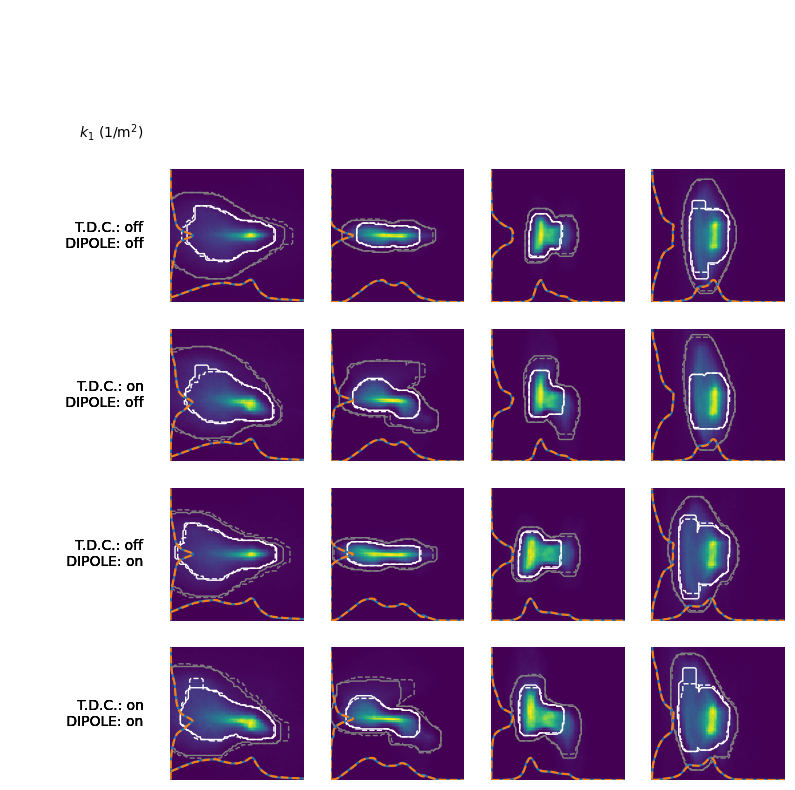

In [14]:
fig, ax = plot_3d_scan_data_2screens_contour2(pred_dset_3d_scan,train_dset_3d_scan,screen_0_len=150,screen_1_len=150)
fig.savefig("facet_ii_pred_images_comparison.svg")

In [ ]:
from stats import plot_projections_with_contours,show_cov_stats,get_cov,plot_cov_sigmas
frac = 0.9
cov_gt_frac = get_cov(gt_beam.numpy_particles(), beam_fraction=frac)
cov_reconstruction_frac = get_cov(recn_dist.numpy_particles(), beam_fraction=frac)

In [ ]:
frac_error = cov_gt_frac - cov_reconstruction_frac
mask = np.tri(cov_sigmas.shape[0],k=-1)

mask = np.tri(frac_error.shape[0],k=-1)
frac_error = np.flipud(np.ma.array(frac_error, mask=mask))

manipulated_cov_gt = np.flipud(cov_gt_frac).T
manipulated_cov_recon = np.flipud(cov_reconstruction_frac).T


def plot_cov_sigmas(frac_error, fig=None):
    coords = ('x', '$p_x$', 'y', '$p_y$', 'z', '$p_z$')
    
    if fig is None:
        fig, ax = plt.subplots()
    else:
        center = 0.375
        cax_width = 0.025
        buffer = 0.05
        ax_width = 1-center-cax_width - buffer
        ax = fig.add_axes([center, center, ax_width, ax_width],zorder=0)
        #cax = fig.add_axes([center + ax_width + buffer, center, cax_width, ax_width],zorder=0)
        
    c = ax.pcolormesh(manipulated_cov_gt, cmap='seismic', vmin=-100, vmax=100, alpha=0.0)
    for (j,i), label in np.ndenumerate(cov_sigmas):
        if not frac_error.mask[i,j]:
            ax.text(i + 0.5, j + 0.5, f'{manipulated_cov_gt[i,j]*1e6:.2f}\n{manipulated_cov_recon[i,j]*1e6:.2f}', ha='center', va='center')
    #fig.colorbar(c,cax=cax,label="Covariance fractional error")
    ax.set_xticks(np.arange(len(coords))+0.5, labels=coords)
    ax.set_yticks(np.arange(len(coords))+0.5, labels=coords[::-1])
    
    ax.xaxis.tick_top()
    ax.yaxis.tick_right()
    
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    #fig.tight_layout()
    
    ax.set_title("Covariance prediction comparison")

    return fig, ax

fig, ax = plot_cov_sigmas(frac_error,fig)
a = fig.get_axes()[:-10]
for ele in a:
    ele.zorder=10

fig.set_size_inches(7,7)
fig.savefig("gaussian_reconstruction.png",dpi=300)
fig.savefig("gaussian_reconstruction.svg")
fig

In [ ]:
torch.cuda.empty_cache()